<h1 align="center">Relicating Vision Transformer</h1>

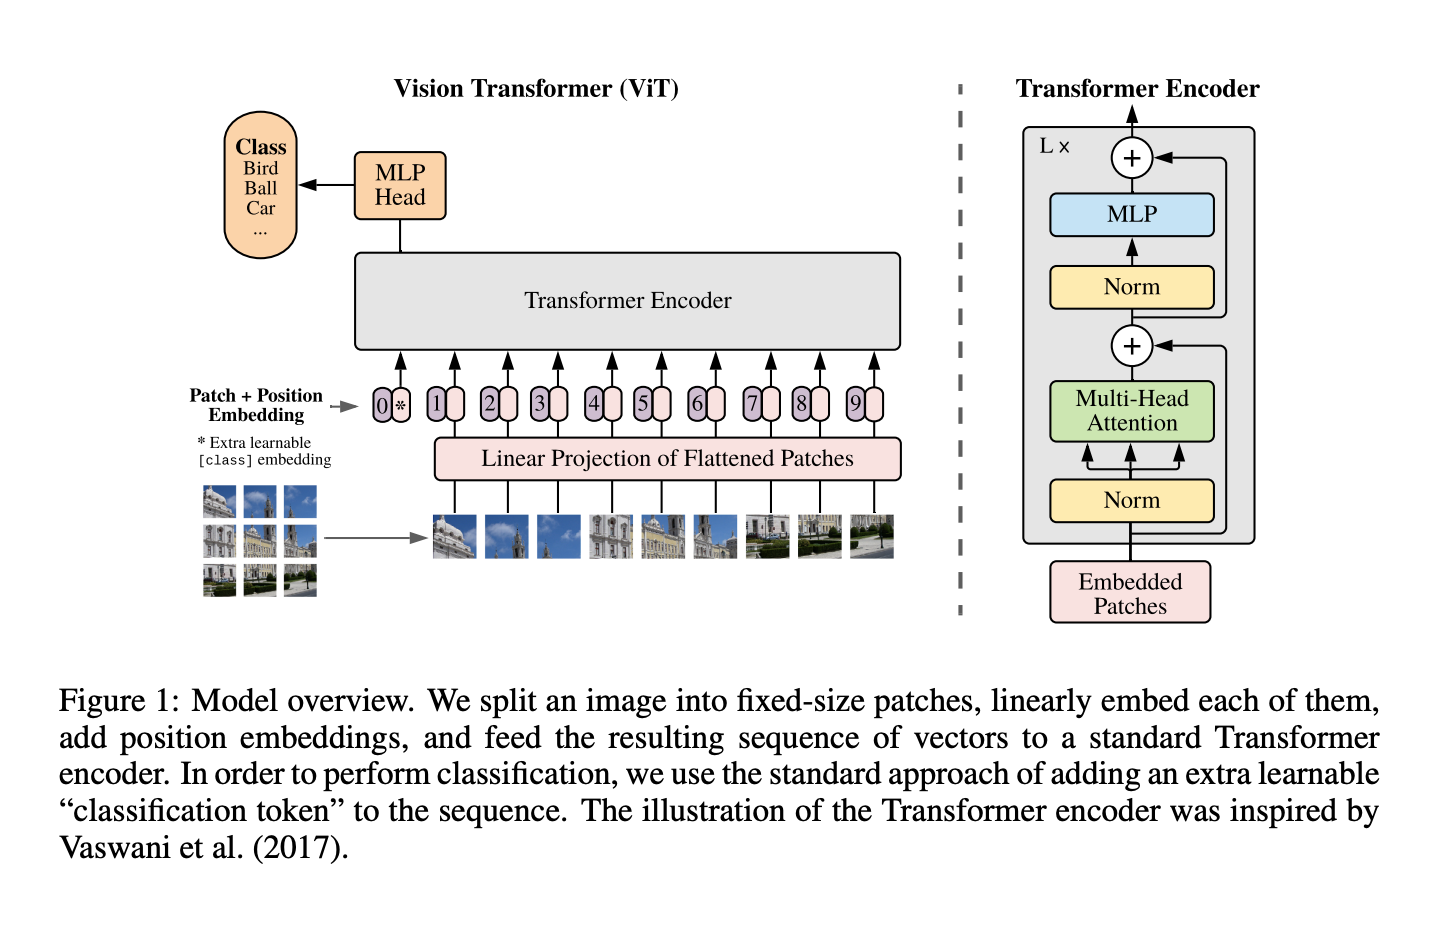

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import torch
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from torch import nn
from torchvision import transforms

from torchinfo import summary

from HelperFunctions import download_data, set_seeds, plot_loss_curves

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"
     
train_dir, test_dir

[INFO] data\pizza_steak_sushi directory exists, skipping download.


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [4]:
IMG_SIZE = 224
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])

In [5]:
BATCH_SIZE = 32

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_datset = datasets.ImageFolder(test_dir, transform=transform)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloder = DataLoader(dataset=test_datset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

len(train_dataset),len(test_datset),len(train_dataloader), len(test_dataloder)

(225, 75, 8, 3)

(-0.5, 223.5, 223.5, -0.5)

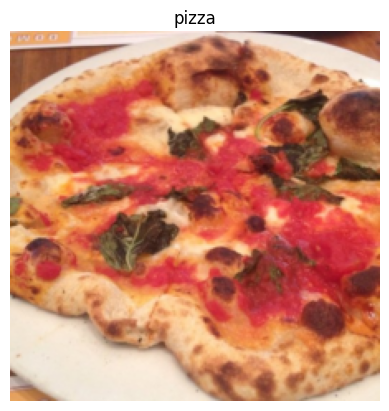

In [6]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(train_dataset.classes[label])
plt.axis(False)

In [7]:
height = 224
width = 224
color_channels = 3
patch_size = 16 

number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [8]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


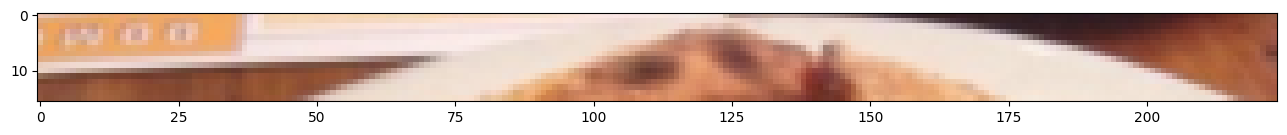

In [9]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


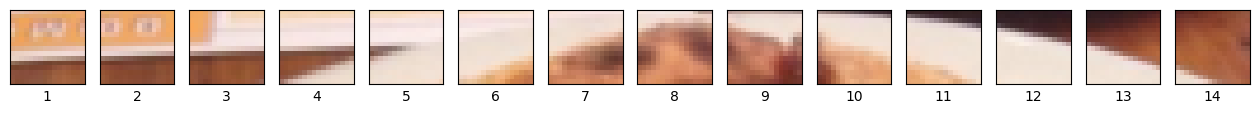

In [10]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

In [11]:
height = 224
width = 224
image_size = height * width
patch_size = 16

num_patches = image_size // patch_size**2

#fig, axs = plt.subplots(nrows=width // patch_size, ncols=height // patch_size, sharex=True, sharey=True, figsize=(width/patch_size, height/patch_size))

# for i, col_patch in enumerate(range(0, height, patch_size)):
#     for j, row_patch in enumerate(range(0, width, patch_size)):
#         axs[i,j].imshow(image_permuted[col_patch:col_patch+patch_size, row_patch:row_patch+patch_size, :])
#         axs[i,j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
#         axs[i,j].set_xlabel(j+1)
#         axs[i,j].set_xticks([])
#         axs[i,j].set_yticks([])
#         axs[i,j].label_outer()
# fig.suptitle(f"{test_datset.classes[label]} -> Patchified", fontsize=14)
# plt.show()

In [12]:
conv2d = nn.Conv2d(in_channels=3, #colors
                   out_channels=768, # D size from Table 1 for ViT-Base
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [13]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, embedding_dim, height, width)
print(image_out_of_conv.shape) 
     

torch.Size([1, 768, 14, 14])


In [14]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
image_out_of_conv_flattend = flatten_layer(image_out_of_conv)
image_out_of_conv_flattend.shape

torch.Size([1, 768, 196])

In [15]:
image_out_of_conv_flattend = image_out_of_conv_flattend.permute(0, 2, 1)
print(f"{image_out_of_conv_flattend.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


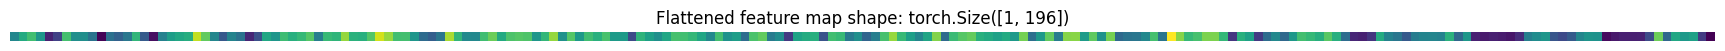

In [16]:
single_flattened_feature_map = image_out_of_conv_flattend[:, :, 2]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False); 

In [17]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size
  
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
    
  def forward(self, x):
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
      x_patched = self.patcher(x) 
      x_flattened = self.flatten(x_patched)
      return x_flattened.permute(0, 2, 1)

In [18]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, 
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:int=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout, 
                                                batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output
        


In [19]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
    
    # Create the norm layer (LN) 
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout) 
    )
  
  def forward(self, x):
    x = self.layer_norm(x) 
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) # same as above 

In [20]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    
    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim, 
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
    
  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x 

In [21]:
#LOL
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [22]:
# Create a ViT class 
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16, 
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    
    # Create learnable position embedding 
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    
    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    
    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )
  
  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions
    
    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)
    
    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])
    
    return x 
  

In [23]:
vit = ViT(num_classes=len(train_dataset.classes)).to(DEVICE)

In [24]:

from py_scripts import engine

optimizer = torch.optim.Adam(vit.parameters(), 
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train_model_epochs(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloder,
                       epochs=1,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       writer= None,
                       device=DEVICE)

c:\Users\muhammad.sultan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\muhammad.sultan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


TrainAccuracy:: 43.36%
TestAccuracy:: 19.79%


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


In [25]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(DEVICE)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

In [26]:
# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(train_dataset.classes)).to(DEVICE)

In [27]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [28]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [29]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [31]:
from py_scripts import data_setup
train_dataloader_pretrained, test_dataloader_pretrained = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # could set a higher batch size because using a pretrained model 

In [35]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds() 
pretrained_vit_results = engine.train_model_epochs(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      writer = None,
                                      device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

TrainAccuracy:: 71.88%
TestAccuracy:: 87.69%


 10%|█         | 1/10 [00:02<00:19,  2.15s/it]

TrainAccuracy:: 94.53%
TestAccuracy:: 89.77%


 20%|██        | 2/10 [00:03<00:15,  1.95s/it]

TrainAccuracy:: 94.92%
TestAccuracy:: 91.86%


 30%|███       | 3/10 [00:05<00:13,  1.89s/it]

TrainAccuracy:: 96.09%
TestAccuracy:: 91.86%


 40%|████      | 4/10 [00:07<00:11,  1.87s/it]

TrainAccuracy:: 97.27%
TestAccuracy:: 89.77%


 50%|█████     | 5/10 [00:09<00:09,  1.85s/it]

TrainAccuracy:: 97.66%
TestAccuracy:: 92.80%


 60%|██████    | 6/10 [00:11<00:07,  1.85s/it]

TrainAccuracy:: 97.66%
TestAccuracy:: 88.83%


 70%|███████   | 7/10 [00:13<00:05,  1.86s/it]

TrainAccuracy:: 98.44%
TestAccuracy:: 90.81%


 80%|████████  | 8/10 [00:15<00:03,  1.85s/it]

TrainAccuracy:: 98.83%
TestAccuracy:: 93.84%


 90%|█████████ | 9/10 [00:16<00:01,  1.85s/it]

TrainAccuracy:: 99.22%
TestAccuracy:: 91.76%


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]
